In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

Load data

In [18]:
# Load data
data = pd.read_csv("../data/AlarmGrundlag_ModelParametre_Merged1.1.csv", delimiter=";")
data = data.drop(columns=["Customer_Refnr", "RUN_DATE", "CASE_CLOSE_DATE", "SCENARIO_NAME", "ALERT_ID", "CASE_ID", "Customer_Risk_Profile_Current"])
data['CASE_STATUS_CODE'] = data['CASE_STATUS_CODE'].replace({'C': 0, 'R': 1})
data.dropna(subset=['Customer_Risk_Profile_BeforeAlert'], inplace=True)
data = pd.get_dummies(data, columns=['Customer_Risk_Profile_BeforeAlert'], prefix='RiskGroup')
# Replace infinities with NaN for easier handling
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with any NaNs that might have been infinities initially
data.dropna(inplace=True)



C:\Users\piciu\AppData\Local\Temp\ipykernel_45172\3571786198.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['CASE_STATUS_CODE'] = data['CASE_STATUS_CODE'].replace({'C': 0, 'R': 1})


Apply log transform

In [19]:
columns_to_log = ['Express_Ratio_SumDKK', 'Express_Ratio_Count', 'MobilePay_Count_DebitCreditRatio', 'MobilePay_Sum_DebitCreditRatio']
for column in columns_to_log:
    data[column] = np.log1p(data[column])

Prepare features and target

In [20]:
y = data['CASE_STATUS_CODE']
X = data.drop('CASE_STATUS_CODE', axis=1)
#X = X.astype(float).replace([np.inf, -np.inf], np.nan).dropna()


Scale and PCA

In [28]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Note: transform, not fit_transform!

# Apply PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)  # Transform test data using the same PCA model


Plot Cumulative Variance

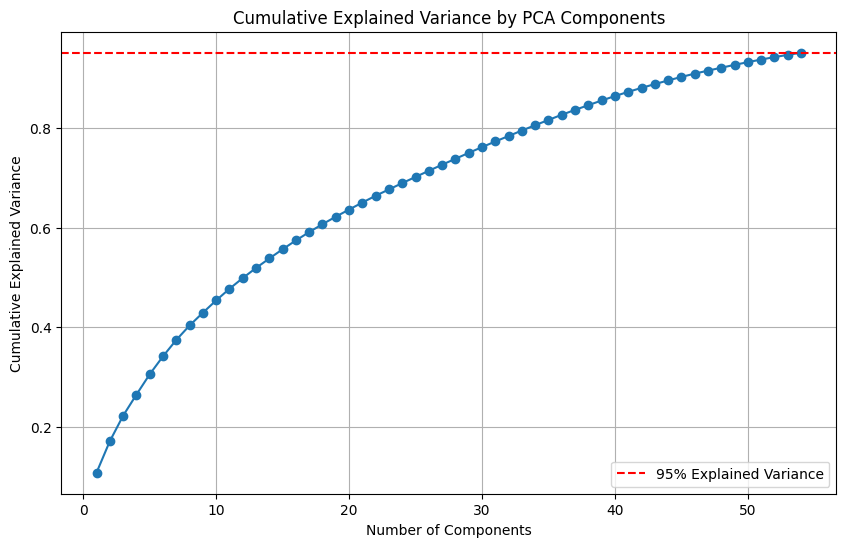

In [29]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show()

# Histogram for target variable

Class Imbalance in %:
 CASE_STATUS_CODE
0    81.896552
1    18.103448
Name: count, dtype: float64


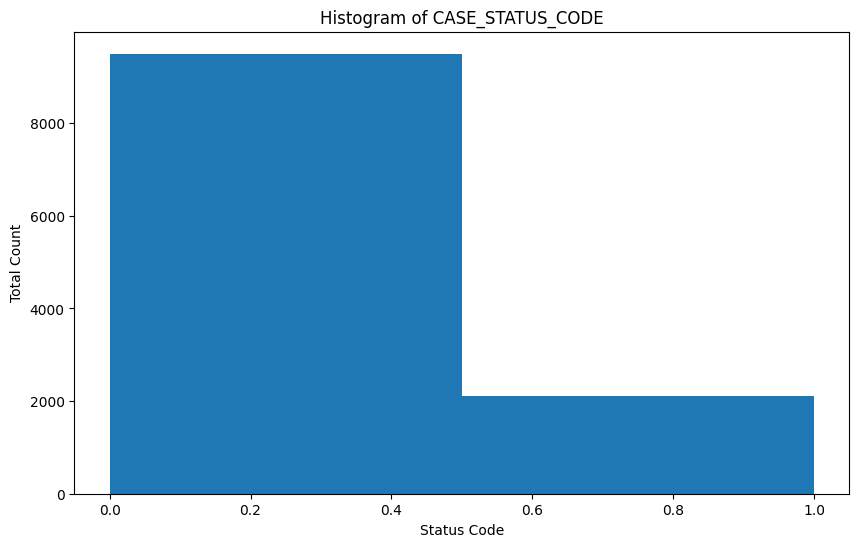

In [33]:
class_counts = data['CASE_STATUS_CODE'].value_counts()
class_percentage = class_counts / len(data) * 100
print("Class Imbalance in %:\n", class_percentage)
plt.figure(figsize=(10, 6))
data['CASE_STATUS_CODE'].hist(bins=len(class_counts))
plt.title('Histogram of CASE_STATUS_CODE')
plt.xlabel('Status Code')
plt.ylabel('Total Count')
plt.grid(False)
plt.show()

Class Imbalance in %:
 CASE_STATUS_CODE
0    16.37931
1     3.62069
Name: count, dtype: float64


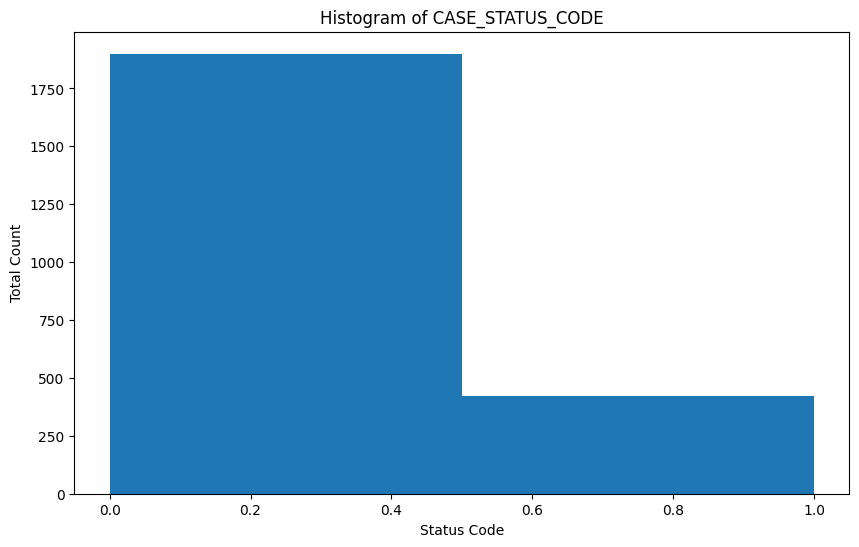

In [58]:
class_counts = y_test.value_counts()
class_percentage = class_counts / len(data) * 100
print("Class Imbalance in %:\n", class_percentage)
plt.figure(figsize=(10, 6))
y_test.hist(bins=len(class_counts))
plt.title('Histogram of CASE_STATUS_CODE')
plt.xlabel('Status Code')
plt.ylabel('Total Count')
plt.grid(False)
plt.show()

In [36]:
corr_matrix = data.corr()

# Extract the correlations of all columns with 'XYZ'
correlation_with_y = corr_matrix['CASE_STATUS_CODE'].drop('CASE_STATUS_CODE')  # Drop the correlation of 'XYZ' with itself

# Convert to DataFrame for better presentation and sorting
correlation_df = correlation_with_y.to_frame(name='CASE_STATUS_CODE')

# Sort by correlation in descending order
sorted_correlation_df = correlation_df.sort_values(by='CASE_STATUS_CODE', ascending=False)

print(sorted_correlation_df)

                                 CASE_STATUS_CODE
Express_Ratio_Count                      0.335936
Customer_Large_Deposits                  0.318792
Express_Ratio_SumDKK                     0.293272
MobilePay_Credit_SumDKK                  0.252347
Express_12mo_Debit_Count                 0.247757
...                                           ...
RiskGroup_1.0                           -0.110938
Customer_has_InstallmentPension         -0.119876
Customer_since_Number_of_Days           -0.134474
Customer_can_Overdraft                  -0.140684
Customer_Age                            -0.171792

[84 rows x 1 columns]


In [72]:
plt.bar(sorted_correlation_df)

TypeError: bar() missing 1 required positional argument: 'height'

In [45]:
print(len(X_train_pca))
print(len(X_test))
print(len(X_train_pca) + len(X_test))

9280
2320
11600


# Logistic Regression with Grid Search


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 0.01, 'solver': 'liblinear'}
Best cross-validation ROC-AUC: 0.8430545112781955
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1900
           1       0.45      0.70      0.55       420

    accuracy                           0.79      2320
   macro avg       0.69      0.75      0.70      2320
weighted avg       0.84      0.79      0.81      2320

Test ROC-AUC: 0.8408020050125314
Test AU-PRC: 0.5382260609953039
Confusion Matrix:
[[1536  364]
 [ 126  294]]


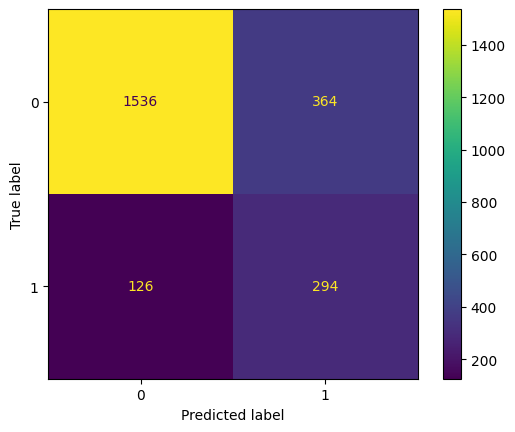

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Assuming X_train_pca, y_train, X_test_pca, and y_test are already defined

# Setup Logistic Regression with balanced class weights
model = LogisticRegression(class_weight='balanced', random_state=42)
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga']}

# Use GridSearchCV to find the best parameters and use AU-PRC as one of the evaluation metrics
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Results
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation ROC-AUC:", grid_search.best_score_)

# Making predictions
predictions = grid_search.best_estimator_.predict(X_test_pca)
probabilities = grid_search.best_estimator_.predict_proba(X_test_pca)[:, 1]

# Calculate precision and recall for each threshold of the ROC
precision, recall, thresholds = precision_recall_curve(y_test, probabilities)

# Compute the area under the precision-recall curve
pr_auc = auc(recall, precision)

# Display results
print(classification_report(y_test, predictions))
print("Test ROC-AUC:", roc_auc_score(y_test, probabilities))
print("Test AU-PRC:", pr_auc)

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

plt.show()

              precision    recall  f1-score   support

           0       0.96      0.56      0.71      1900
           1       0.31      0.90      0.46       420

    accuracy                           0.62      2320
   macro avg       0.64      0.73      0.59      2320
weighted avg       0.84      0.62      0.67      2320

Confusion Matrix:
[[1536  364]
 [ 126  294]]


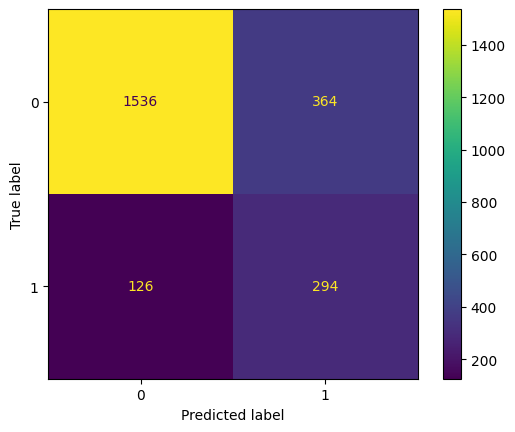

In [66]:
optimal_threshold = 0.295  # test value
predictions_adjusted = (probabilities > optimal_threshold).astype(int)
print(classification_report(y_test, predictions_adjusted))

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

plt.show()

# Random Forest with SMOTE

In [47]:
# Higher recall than without
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Create a pipeline with SMOTE and RandomForest
pipeline = make_pipeline(SMOTE(random_state=42), RandomForestClassifier(random_state=42, class_weight='balanced'))

# Train model
pipeline.fit(X_train, y_train)

# Predict and evaluate (using appropriate metrics)
from sklearn.metrics import classification_report
predictions = pipeline.predict(X_test)
probabilities = pipeline.predict_proba(X_test)[:, 1]  # probabilities for the positive class
print(classification_report(y_test, predictions))
print("ROC-AUC Score:", roc_auc_score(y_test, probabilities))
# Calculate precision-recall pairs
precision, recall, _ = precision_recall_curve(y_test, probabilities)

# Calculate AUPRC
pr_auc = auc(recall, precision)

# Print classification report and AU-PRC
print("AU-PRC:", pr_auc)

# Example of adjusting the classification threshold
optimal_threshold = 0.3  # test value
predictions_adjusted = (probabilities > optimal_threshold).astype(int)
print(classification_report(y_test, predictions_adjusted))


              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1900
           1       0.76      0.74      0.75       420

    accuracy                           0.91      2320
   macro avg       0.85      0.84      0.85      2320
weighted avg       0.91      0.91      0.91      2320

ROC-AUC Score: 0.9405476190476191
AU-PRC: 0.8459768620171344
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1900
           1       0.59      0.87      0.71       420

    accuracy                           0.87      2320
   macro avg       0.78      0.87      0.81      2320
weighted avg       0.90      0.87      0.88      2320



              precision    recall  f1-score   support

           0       0.97      0.85      0.91      1900
           1       0.57      0.90      0.70       420

    accuracy                           0.86      2320
   macro avg       0.77      0.87      0.80      2320
weighted avg       0.90      0.86      0.87      2320

Confusion Matrix:
[[1802   98]
 [ 109  311]]


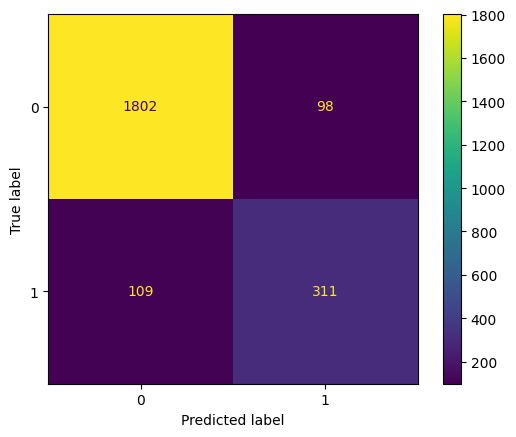

In [61]:
optimal_threshold = 0.27  # test value
predictions_adjusted = (probabilities > optimal_threshold).astype(int)
print(classification_report(y_test, predictions_adjusted))

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

plt.show()

# Imbalanced Learn Random Forest with AUPRC

In [69]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, auc
from sklearn.metrics import precision_recall_curve, make_scorer

# Prepare the data (assuming X and y are already defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],  # Corrected from 'auto'
    'class_weight': [{0: 1, 1: v} for v in [1, 2, 3, 4, 5, 10, 20]]
}

param_dist = {'n_estimators': [300], 'min_samples_leaf': [1], 'max_features': ['sqrt'], 'max_depth': [None], 'class_weight': [{0: 1, 1: 1}]}

# Initialize the BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(random_state=42, bootstrap=True, replacement=False)  # Explicitly set changing parameters

# Custom scorer for AUPRC
pr_auc_scorer = make_scorer(lambda y_true, y_score: auc(*precision_recall_curve(y_true, y_score)[:2][::-1]), needs_proba=True)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(brf, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, n_jobs=-1, scoring=pr_auc_scorer)
random_search.fit(X_train, y_train)

# Display the best parameters and best score
print("Best parameters found: ", random_search.best_params_)

C:\Users\piciu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
C:\Users\piciu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\piciu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(


Best parameters found:  {'n_estimators': 300, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': {0: 1, 1: 1}}


In [70]:
# Evaluate the best model
best_brf = random_search.best_estimator_
y_pred = best_brf.predict(X_test)
y_pred_prob = best_brf.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print("Average Precision-Recall Score (AUPRC):", pr_auc)
print(classification_report(y_test, y_pred))


Average Precision-Recall Score (AUPRC): 0.8336667310202436
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      1900
           1       0.55      0.87      0.68       420

    accuracy                           0.85      2320
   macro avg       0.76      0.86      0.79      2320
weighted avg       0.89      0.85      0.86      2320



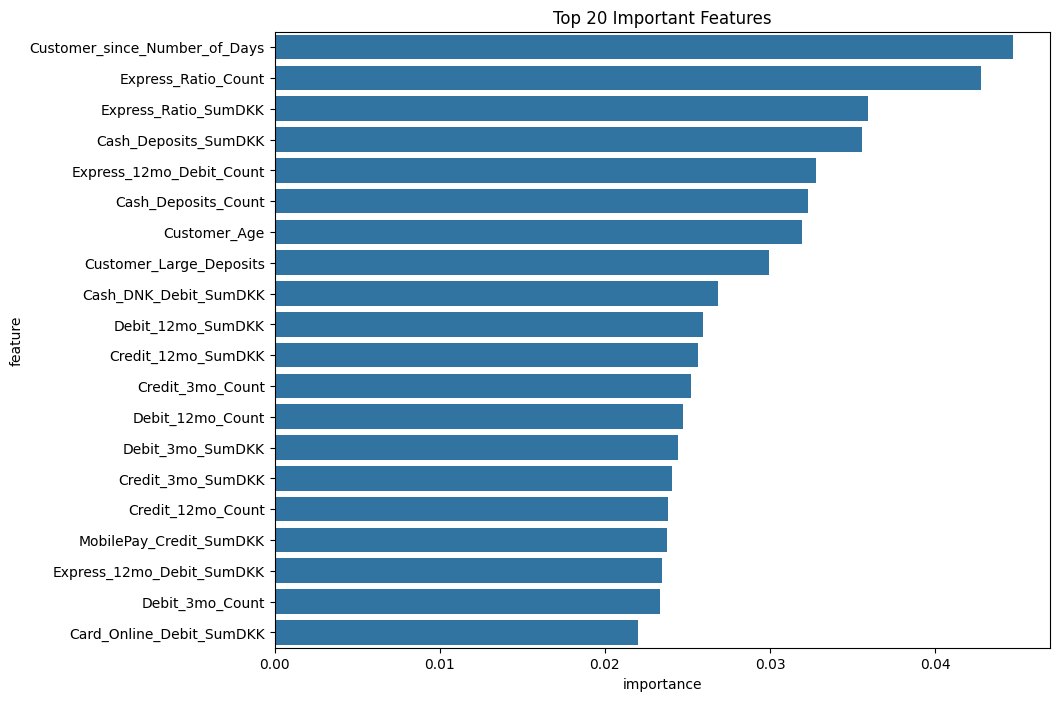

In [179]:
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
plt.title('Top 20 Important Features')
plt.show()


# XGBoost

In [177]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, average_precision_score

# Assuming X_train, X_test, y_train, y_test are already defined from:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3]
}

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', seed=42)

# Custom scorer for AUPRC
auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Setting up GridSearchCV with the AUPRC scorer
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring=auprc_scorer, n_jobs=-1, cv=3, verbose=3)
grid_search.fit(X_train, y_train)



C:\Users\piciu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=No...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5, 6],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring=make_scorer(average_precision_score, response_method='predict_proba'),
             verbose=3)

In [178]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Evaluation metrics
print("Best parameters found: ", best_params)
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print("AU-PRC:", pr_auc)
# Prepare a DMatrix if needed for separate direct XGBoost CV (not needed for GridSearchCV)
data_dmatrix = xgb.DMatrix(data=X, label=y)

# Cross-validation
cv_results = xgb.cv(dtrain=data_dmatrix, params=best_params, nfold=5,
                    num_boost_round=100, early_stopping_rounds=10,
                    metrics="aucpr", as_pandas=True, seed=42)

print(f"Mean AUPRC of the test set: {cv_results['test-aucpr-mean'].iloc[-1]}")  # mean AUPRC score of the test set

Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1900
           1       0.86      0.69      0.76       420

    accuracy                           0.92      2320
   macro avg       0.90      0.83      0.86      2320
weighted avg       0.92      0.92      0.92      2320

ROC-AUC Score: 0.9328984962406015
AU-PRC: 0.837808632065747


C:\Users\piciu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:06:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Mean AUPRC of the test set: 0.7913416991748637


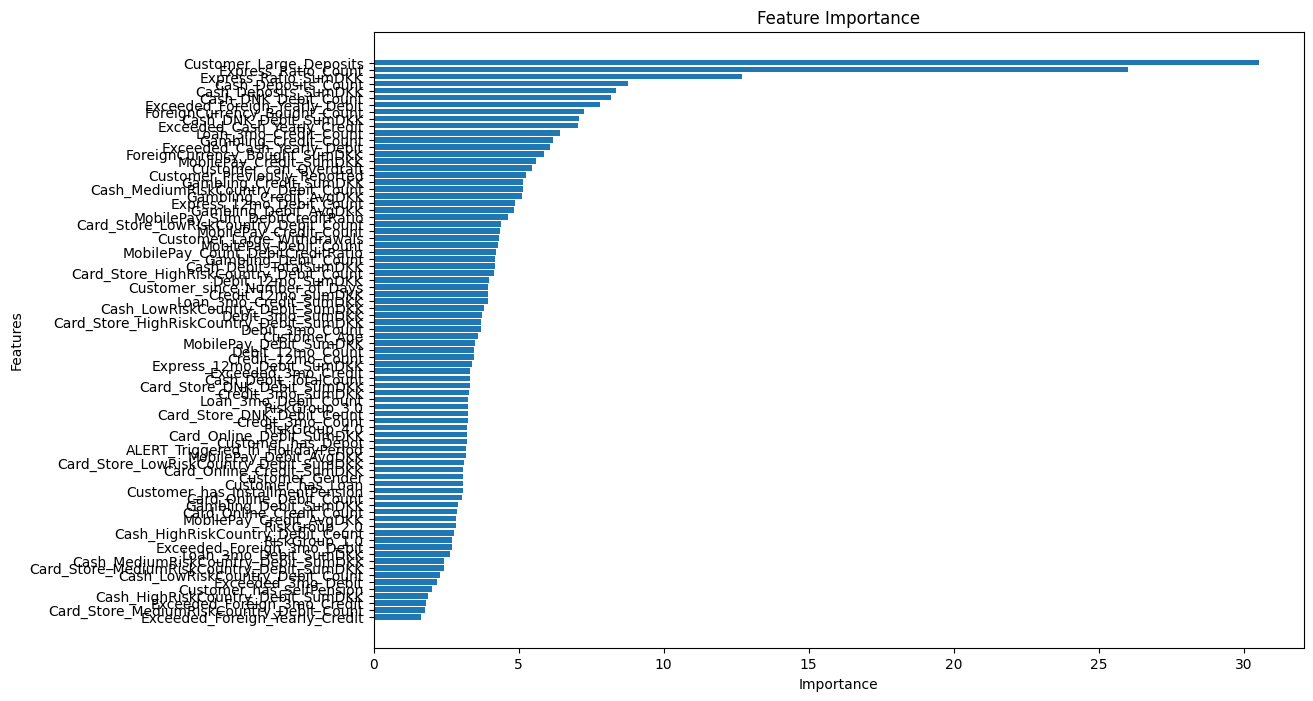

In [175]:
feature_importance = best_model.get_booster().get_score(importance_type='gain')

# Convert feature importance dictionary into a DataFrame
f_importances = pd.DataFrame(list(feature_importance.items()), columns=['feature', 'importance'])

# Sort the DataFrame by importance
f_importances.sort_values(by='importance', ascending=False, inplace=True)
plt.figure(figsize=(12, 8))
plt.barh(f_importances['feature'], f_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the Y-axis to show the most important feature at the top
plt.show()

# CatBoost

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score

# Assuming 'data' is your DataFrame and 'target' is your target column
dataCB = pd.read_csv("../data/AlarmGrundlag_ModelParametre_Merged1.1.csv", delimiter=";")
dataCB = dataCB.drop(columns=["Customer_Refnr", "RUN_DATE", "CASE_CLOSE_DATE", "SCENARIO_NAME", "ALERT_ID", "CASE_ID", "Customer_Risk_Profile_Current"])
dataCB['Customer_Risk_Profile_BeforeAlert'] = dataCB['Customer_Risk_Profile_BeforeAlert'].astype('string')
dataCB['CASE_STATUS_CODE'] = dataCB['CASE_STATUS_CODE'].replace({'C': 0, 'R': 1})
# Replace infinities with NaN for easier handling
dataCB.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with any NaNs that might have been infinities initially
dataCB.dropna(inplace=True)
dataCB.dropna(subset=['Customer_Risk_Profile_BeforeAlert'], inplace=True)

X = dataCB.drop('CASE_STATUS_CODE', axis=1)
y = dataCB['CASE_STATUS_CODE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Specify the categorical features list
cat_features = ['Customer_Risk_Profile_BeforeAlert']

# Custom scorer for GridSearchCV based on AU-PRC
au_prc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Parameter grid for GridSearchCV
param_grid = {
    'scale_pos_weight': [5],
    'depth': [8],
    'learning_rate': [0.5],
    'iterations': [300],
    'l2_leaf_reg': [5],
    'border_count': [32]
}

# Initialize CatBoostClassifier
model = CatBoostClassifier(loss_function='Logloss',
                           eval_metric='AUC',
                           cat_features=cat_features,
                           verbose=200,
                           early_stopping_rounds=50)

# Setup GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=au_prc_scorer, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation AU-PRC:", grid_search.best_score_)

# Fit the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Predict probabilities
probabilities = best_model.predict_proba(X_test)[:, 1]

# Calculate AU-PRC
precision, recall, _ = precision_recall_curve(y_test, probabilities)
pr_auc = auc(recall, precision)
print("Test AU-PRC:", pr_auc)


C:\Users\piciu\AppData\Local\Temp\ipykernel_45172\4100566588.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataCB['CASE_STATUS_CODE'] = dataCB['CASE_STATUS_CODE'].replace({'C': 0, 'R': 1})
C:\Users\piciu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	total: 120ms	remaining: 35.8s
200:	total: 23.3s	remaining: 11.5s
299:	total: 34.7s	remaining: 0us
Best parameters: {'border_count': 32, 'depth': 8, 'iterations': 300, 'l2_leaf_reg': 6, 'learning_rate': 0.5, 'scale_pos_weight': 5}
Best cross-validation AU-PRC: 0.7819038675267735
0:	test: 0.7753114	best: 0.7753114 (0)	total: 110ms	remaining: 32.9s
200:	test: 0.9241385	best: 0.9241385 (200)	total: 23.3s	remaining: 11.5s
299:	test: 0.9264185	best: 0.9266122 (293)	total: 35.2s	remaining: 0us

bestTest = 0.9266121554
bestIteration = 293

Shrink model to first 294 iterations.
Test AU-PRC: 0.8202999456223315
